Project 2: Web Scraping and Regression<br/>

The goal of this project is to build a linear regression model to predict some numerical value using data scraped from the world wide web.

For this project, I scraped Craigslist car postings in the SF Bay Area. The time period for my scrape was between July 10,2020 and July 12,2020. I collect attributen and see how they correlate with price, my target variable.

In this notebook, I use my cleaned DataFrame to build a linear regression model. I optimize my model by removing features. I cross validate and test my model. Finally, I interpret my results.

### Table of Contents
1. Imports
2. Checking Assumptions
3. Exploratory Regression
4. Cross-Validation and Testing
5. Results

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# regression imports

import scipy.stats as stats

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import lars_path
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

from yellowbrick.regressor import ResidualsPlot

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#### 2. Checking Assumptions
Examine my data and check if it fulfills the assumptions to perform linear regression. If it doesn't fulfill an assumption, I apply fixes to my data to address it.

In [3]:
# open up cleaned DataFrame
with open('data/cleaned_car_df.pickle', 'rb') as read_file:
    car_df = pickle.load(read_file)

In [56]:
car_df.head()

,fuel,odometer,title_status,transmission,year,price,location,attribute_number,post_title_length,car_age,car_age_log,odometer_log,price_log
0,gas,160000.0,salvage,automatic,2013,10300.0,east_bay,13,43,8,2.079442,11.982929,9.239899
1,gas,36368.0,clean,automatic,2017,34800.0,north_bay,15,25,4,1.386294,10.501445,10.457373
2,gas,59541.0,clean,other,2013,17900.0,santa_cruz,13,42,8,2.079442,10.994420,9.792556
3,gas,102693.0,clean,automatic,2013,8499.0,san_francisco,12,38,8,2.079442,11.539499,9.047704
4,gas,64183.0,clean,automatic,2012,6499.0,san_francisco,12,39,9,2.197225,11.069494,8.779404


In [9]:
# make a copy of the original dataframe to do regression tests
regression_test_df = car_df.copy()

Information from my exploratory data analysis (EDA):<br /> 
* For making dummy variables, I want to drop the following columns to avoid the dummy variable trap
1. fuel_other
2. title_status parts only
3. location_santa_cruz
* I have log transformations of both price and odometer in my DataFrame. This transformation turns skewed price and odometer data into more normalized distributions.
* I have concerns about using title status in my model. 96% of title status values are "clean". <br />
Columns to drop: odometer (use odometer_log instead), price (use price_log instead), and year (use car_age instead)

##### Evaluation of Linear Regression Model Assumptions.

1. Linear in terms of beta coefficients<br />
2. Error is normally distributed and has population mean of 0.<br />

Note I can only test these assumptions on numerical data, not categorical data (dummy variables) that are bimodal (0's and 1's). I plot a linear regression fit, residual, and Q-Q plot for the numerical data against price (log transformed).

In [9]:
def diagnostic_plot(x, y):
    '''
    This function plots a regression fit, residual plot, and Q-Q plot for a feature against the target.
    The Q-Q plot measures how closely the residuals fit a normal curve.
    Parameters:
        x: a numeric feature from my dataset
        y: target feature, in this case price_log
    '''
    
    
    plt.figure(figsize=(20,5))
    
    lr = LinearRegression()
    lr.fit(x, y)
    pred = lr.predict(x)
    
    plt.subplot(1, 3, 1)
    plt.scatter(x, y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual Plot")
    plt.xlabel("prediction")
    plt.ylabel("residual")
    
    plt.subplot(1, 3, 3)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

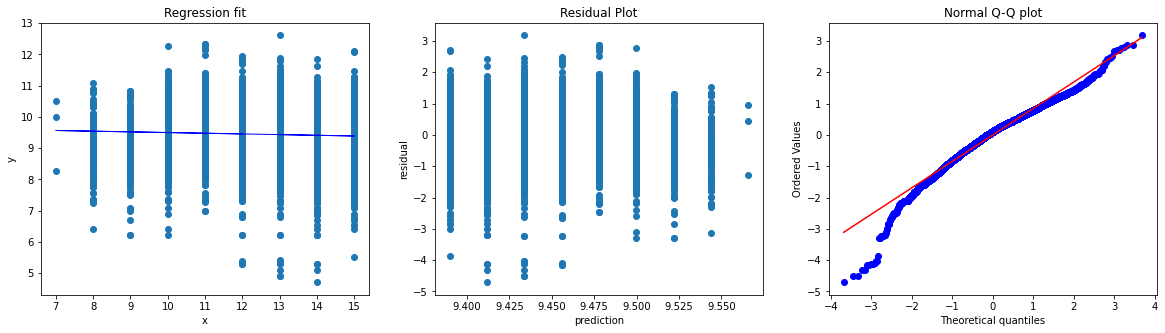

In [10]:
diagnostic_plot(regression_test_df[["attribute_number"]], regression_test_df["price_log"])

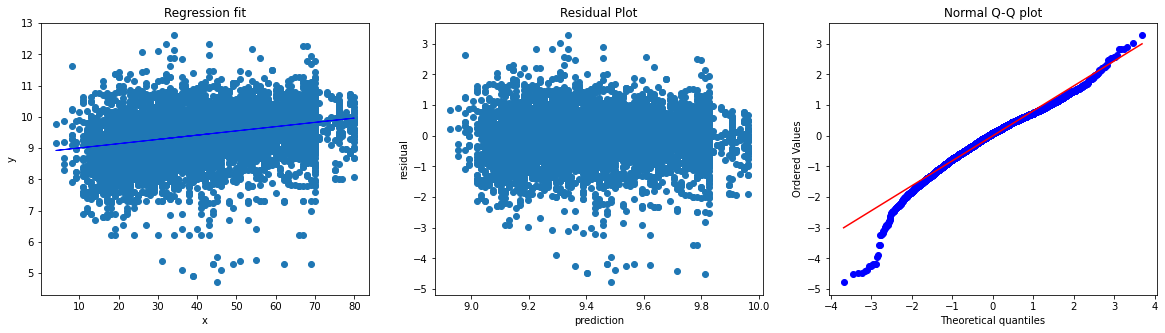

In [11]:
diagnostic_plot(regression_test_df[["post_title_length"]], regression_test_df["price_log"])

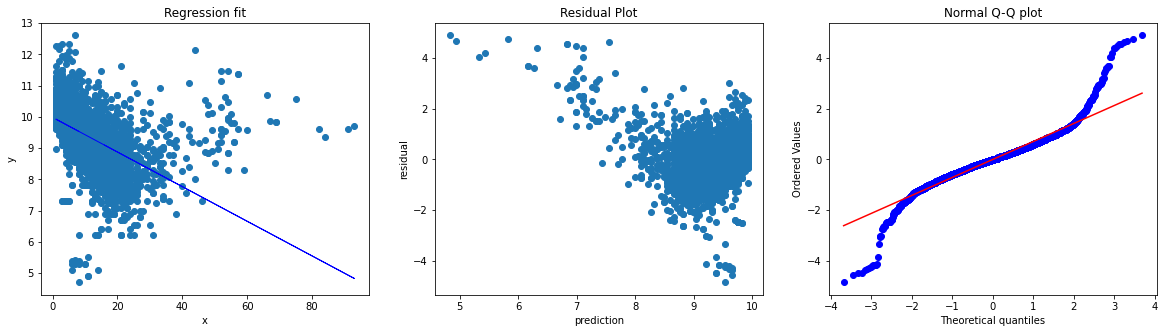

In [12]:
diagnostic_plot(regression_test_df[["car_age"]], regression_test_df["price_log"])

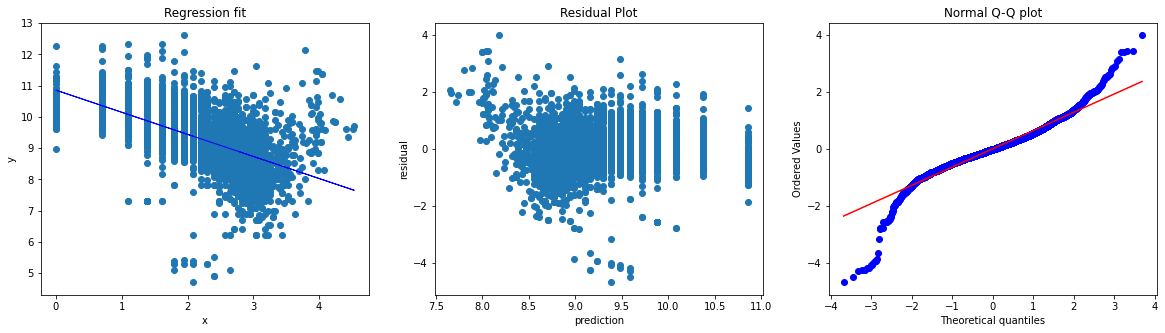

In [13]:
diagnostic_plot(regression_test_df[["car_age_log"]], regression_test_df["price_log"])

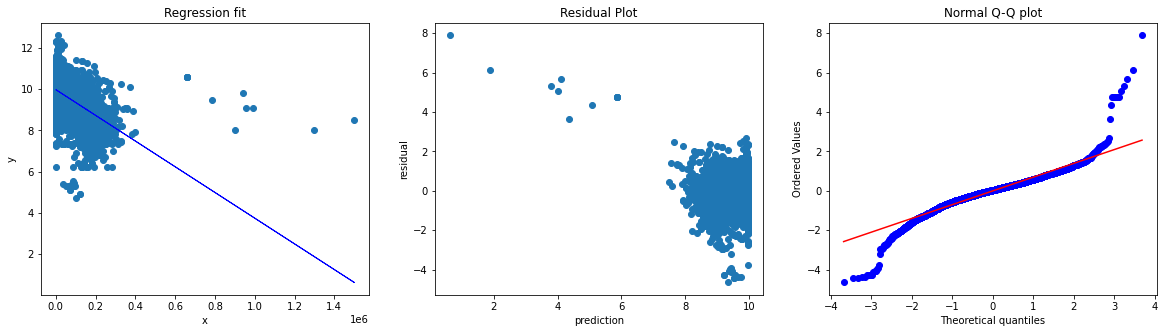

In [14]:
diagnostic_plot(regression_test_df[["odometer"]], regression_test_df["price_log"])

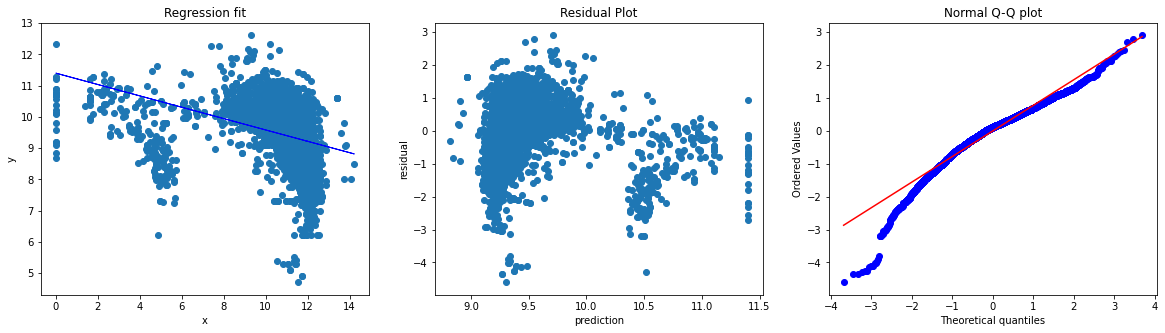

In [15]:
diagnostic_plot(regression_test_df[["odometer_log"]], regression_test_df["price_log"])

Analysis:<br/>
Attribute number and post title length Q-Q plots look okay. They have a tail at low quantiles. <br />
All the log transforms (car age and odometer) look better than the untransformed values, so I will use the log transformed values. The residuals are roughly symmetric around y=0 with constant variance. Additionally, the Q-Q plots look closer to the diagonal red line.

3. Error terms must have constant variance<br />
Again, I can only test numeric columns

In [6]:
numeric_cols = ["attribute_number", "post_title_length", "car_age_log", "odometer_log"]

In [10]:
X = regression_test_df[numeric_cols]
Y = regression_test_df["price_log"]

model = sm.OLS(Y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          8.357e+04
Date:                Wed, 15 Jul 2020   Prob (F-statistic):                        0.00
Time:                        14:10:41   Log-Likelihood:                         -10036.
No. Observations:                6067   AIC:                                  2.008e+04
Df Residuals:                    6063   BIC:                                  2.011e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
attribute_number      0.4633      0.007     67.211      0.000       0.450       0.477
post_title_length     0.0288      0.001     31.008      0.000       0.027       0.031
car_age_log          -0.6106      0.024    -25.078      0.000      -0.658      -0.563
odometer_log          0.3229      0.009     35.196      0.000       0.305       0.341
==============================================================================
Omnibus:                      542.731   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.530
Skew:                           0.535   Prob(JB):                    7.98e-287
Kurtosis:                       5.016   Cond. No.                         73.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

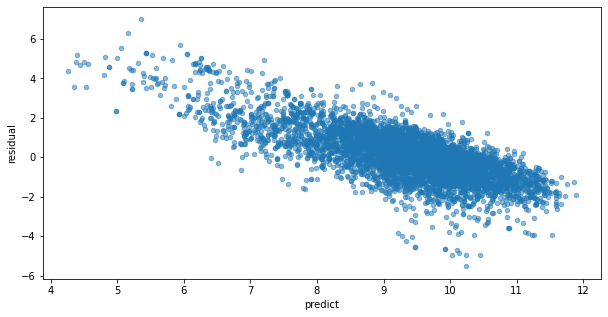

In [11]:
residual_plot = pd.DataFrame()
residual_plot["predict"] = fit.predict(X)
residual_plot["residual"] = Y - residual_plot["predict"]
residual_plot.plot(kind="scatter", x="predict", y="residual", alpha=0.5, figsize=(10,5));

Don't see heteroskedasticity. The errors don't have higher variance when predictions are high or low. However, it looks like the residuals aren't symmetric around 0. There's a slight downward slope.

4. Errors are uncorrelated across observations.<br />
I have no time series data.

5. No independent variable is a perfect linear function of any other independent variables (no perfect multi-collinearity).<br />

Inspect correlation of independent features and keep an eye on condition number. I can fix this by removing variables that are colinear or by using ridge regularization.

In [12]:
drop_cols = ["odometer", "year", "price", "car_age", "price_log"]
correlation_df = regression_test_df.copy()
correlation_df = correlation_df.drop(columns=drop_cols)
correlation_df.head()

,fuel,title_status,transmission,location,attribute_number,post_title_length,car_age_log,odometer_log
0,gas,salvage,automatic,east_bay,13,43,2.079442,11.982929
1,gas,clean,automatic,north_bay,15,25,1.386294,10.501445
2,gas,clean,other,santa_cruz,13,42,2.079442,10.994420
3,gas,clean,automatic,san_francisco,12,38,2.079442,11.539499
4,gas,clean,automatic,san_francisco,12,39,2.197225,11.069494


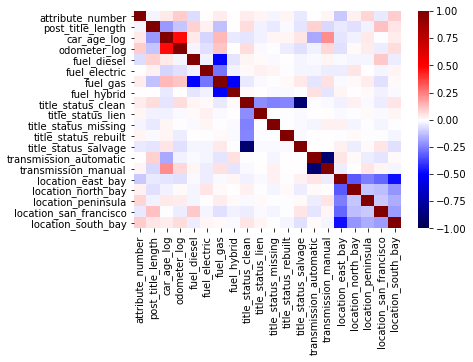

In [13]:
correlation_df = pd.get_dummies(data=correlation_df)
correlation_df = correlation_df.drop(columns=["fuel_other", "title_status_parts only", "transmission_other", "location_santa_cruz"])
sns.heatmap(correlation_df.corr(), cmap='seismic', vmin=-1, vmax=1);

Heatmap Observations:<br/>
There's a strong correlation between car age (log) and odometer (log), fuel gas and fuel diesel, all of the title status attributes and locations. Transmission automatic versus manual is also very strongly correlated. This plot shows that I have colinear issues, so I definitely need to remove features.

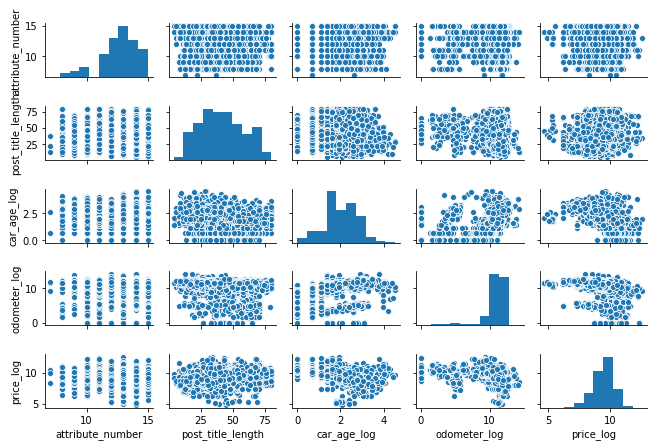

In [14]:
pairplot_df = regression_test_df.copy()
numeric_cols = ["attribute_number", "post_title_length", "car_age_log", "odometer_log", "price_log"]
pairplot_df = pairplot_df.loc[:,numeric_cols]
sns.pairplot(pairplot_df, height=1.2, aspect=1.5);

Pairplot Observations:<br/>
The correlation between car_age_log and odometer_log is harder to spot on the pairplot. Looking at all the features compared to price_log, it's also hard to see a clear pattern or correlation. Not able to glean much information from this.

### 3. Exploratory Regression

Here, I will be exploring different regression models and refining what features I want to include in my model. My workflow for exploratory regression is:<br />
1. Make a train_test_split 80/20 split of my data.
2. Run ordinary least square regression via statsmodel and evaluate the condition number and p values.
3. If I have high condition number, I run RidgeCV. I can also feature engineer collinear features into one. I can also drop features that I think may be collinear.<br />
4. If I have high p values, I run LassoCV to see what features to keep or remove.

#### Exploration One

In [15]:
regression_test_df.head()

,fuel,odometer,title_status,transmission,year,price,location,attribute_number,post_title_length,car_age,car_age_log,odometer_log,price_log
0,gas,160000.0,salvage,automatic,2013,10300.0,east_bay,13,43,8,2.079442,11.982929,9.239899
1,gas,36368.0,clean,automatic,2017,34800.0,north_bay,15,25,4,1.386294,10.501445,10.457373
2,gas,59541.0,clean,other,2013,17900.0,santa_cruz,13,42,8,2.079442,10.994420,9.792556
3,gas,102693.0,clean,automatic,2013,8499.0,san_francisco,12,38,8,2.079442,11.539499,9.047704
4,gas,64183.0,clean,automatic,2012,6499.0,san_francisco,12,39,9,2.197225,11.069494,8.779404


In [6]:
def make_X_df(input_df, remove_cols, remove_dummy_cols):
    '''
    Returns a dataframe that drops removed columns. Additionally, dummy variables are created
    and specified dummy variable columns are also dropped.
    
    Parameters:
        input_df: the input Dataframe I want to remove columns from
        remove_cols: the numeric columns I want to remove
        remove_dummy_cols: the specified categorical dummy column I want to remove (for example: title_status_salvage)
    '''
    X_df = input_df.copy()
    X_df = X_df.drop(columns=remove_cols)
    
    X_df = pd.get_dummies(data=X_df)
    X_df = X_df.drop(columns=remove_dummy_cols)
    
    return X_df

In [5]:
def make_train_test(X, Y):
    '''
    Returns X_train, X_test, Y_train, and Y_test that have been standardized and have constants added
    
    Parameters:
    X: DataFrame of values and columns with the features to test
    Y: Series of target variable values
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=20)
    
    # Standardize the features and add a constant
    scaler = StandardScaler()
    
    master_numeric_cols = ["attribute_number", "post_title_length", "car_age_log", "odometer_log"]
    numeric_cols = []
    
    # only scale numeric columns. Attribute number or post title length could be removed as features
    for column in X.columns:
        if column in master_numeric_cols:
            numeric_cols.append(column)
    
    # base the scale (mean & standard deviation) on the training set
    scaler.fit(X_train[numeric_cols])
    
    # use StandardScaler to scale both the training and test data
    scaled_train_values = scaler.transform(X_train[numeric_cols])
    X_train = X_train.drop(columns=numeric_cols)
    X_train[numeric_cols] = pd.DataFrame(scaled_train_values, index=X_train.index, columns=numeric_cols)
    X_train = sm.add_constant(X_train)
    
    scaled_test_values = scaler.transform(X_test[numeric_cols])
    X_test = X_test.drop(columns=numeric_cols)
    X_test[numeric_cols] = pd.DataFrame(scaled_test_values, index=X_test.index, columns=numeric_cols)
    X_test = sm.add_constant(X_test)
    
    return X_train, X_test, Y_train, Y_test

In [102]:
regression_test_df["post_title_length"].describe()

count    6067.000000
mean       41.781276
std        16.870772
min         4.000000
25%        29.000000
50%        40.000000
75%        54.000000
max        80.000000
Name: post_title_length, dtype: float64

In [112]:
# Prep X(features) and Y(target variable) and use statsmodel to create my first linear regression model
remove_cols = ["odometer", "year", "price", "car_age", "price_log"]
remove_dummy_cols = ["fuel_other", "title_status_parts only", "transmission_other", "location_santa_cruz"]
X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = make_train_test(X, Y)

first_model = sm.OLS(Y_train, X_train)
fit = first_model.fit()

Y_pred = fit.predict(X_test)
print("R^2 Score for test: " + str(r2_score(Y_test, Y_pred)))

fit.summary()

R^2 Score for test: 0.5138819249912536


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     213.3
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:00:10   Log-Likelihood:                -4594.9
No. Observations:                4853   AIC:                             9232.
Df Residuals:                    4832   BIC:                             9368.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8.7247      0.453     19.277      0.000       7.837       9.612
fuel_diesel                0.7070      0.057     12.430      0.000       0.595       0.818
fuel_electric             -0.0236      0.085     -0.279      0.780      -0.190       0.142
fuel_gas                   0.0956      0.040      2.385      0.017       0.017       0.174
fuel_hybrid               -0.0475      0.055     -0.857      0.391      -0.156       0.061
title_status_clean         0.9412      0.442      2.127      0.033       0.074       1.809
title_status_lien          0.9747      0.489      1.992      0.046       0.015       1.934
title_status_missing       0.6798      0.489      1.389      0.165      -0.280       1.639
title_status_rebuilt       0.3670      0.495      0.742      0.458      -0.603       1.337
title_status_salvage       0.4800      0.445      1.078      0.281      -0.393       1.353
transmission_automatic    -0.2783      0.071     -3.905      0.000      -0.418      -0.139
transmission_manual       -0.0850      0.079     -1.076      0.282      -0.240       0.070
location_east_bay         -0.0581      0.055     -1.060      0.289      -0.165       0.049
location_north_bay        -0.0577      0.059     -0.981      0.327      -0.173       0.058
location_peninsula        -0.1507      0.062     -2.436      0.015      -0.272      -0.029
location_san_francisco     0.0300      0.060      0.502      0.616      -0.087       0.147
location_south_bay        -0.0820      0.056     -1.456      0.146      -0.192       0.028
attribute_number           0.0085      0.009      0.929      0.353      -0.009       0.026
post_title_length          0.1091      0.009     11.662      0.000       0.091       0.127
car_age_log               -0.5030      0.011    -46.896      0.000      -0.524      -0.482
odometer_log              -0.0635      0.010     -6.142      0.000      -0.084      -0.043
==============================================================================
Omnibus:                      982.323   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10507.114
Skew:                          -0.653   Prob(JB):                         0.00
Kurtosis:                      10.089   Cond. No.                         237.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Analysis of first regression model:<br/>
Surprisingly, this model doesn't have a high condition number so features don't have a strong colinearity attribute. However, based on the heatmap, I still think there are quite a few values that are colinear. The R^2 value is 0.469, which isn't too bad or good. The adjusted R^2 is around 0.467, which also isn't too different than my R^2. The adjusted R^2 accounts for the number of variables I have in my model. I have quite a few features with high P values, which means the chance I got these coefficients if there's no relationship between that feature and price is quite high. Run LassoCV to see if those features could be removed.

In [84]:
# Run LassoCV on same Dataset

# Make X(features) and Y(target variable) dataframes
remove_cols = ["odometer", "year", "price", "car_age", "price_log"]
remove_dummy_cols = ["fuel_other", "title_status_parts only", "transmission_other", "location_santa_cruz"]
X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = make_train_test(X, Y)

In [85]:
# find the best alpha and refit the model on the data with that alpha
alpha_range = 10**np.linspace(-10,10,1000)
lasso_model = LassoCV(alphas=alpha_range, cv=5)
lasso_model.fit(X_train, Y_train);

In [86]:
print(lasso_model.alpha_) # best alpha is 0.001
print(list(zip(X_train.columns, lasso_model.coef_)))

0.0010642092440647246
[('const', 0.0), ('fuel_diesel', 0.6714827766388133), ('fuel_electric', -0.0), ('fuel_gas', 0.07930775339419839), ('fuel_hybrid', -0.040324101711667434), ('title_status_clean', 0.30981939730783004), ('title_status_lien', 0.0), ('title_status_missing', 0.0), ('title_status_rebuilt', -0.0), ('title_status_salvage', -0.1152726521212693), ('transmission_automatic', -0.20051995833748154), ('transmission_manual', -0.0), ('location_east_bay', -0.0), ('location_north_bay', -0.0), ('location_peninsula', -0.08055834036404486), ('location_san_francisco', 0.08066857030633791), ('location_south_bay', -0.018283838916036053), ('attribute_number', 0.0059282068256511725), ('post_title_length', 0.10729211679826638), ('car_age_log', -0.5033208026929035), ('odometer_log', -0.06283822544494484)]


In [10]:
# Calculate mean absolute error; may use this function later
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [134]:
car_df["title_status"].value_counts()

clean         5840
salvage        186
missing         14
rebuilt         13
lien            12
parts only       2
Name: title_status, dtype: int64

Based on the p-values in my OLS summary table and the 0 coefficient values, I can remove fuel_electric, title_status_lien, title_status_missing, title_status_rebuilt, transmission_manual, location_east_bay, location_north_bay features from my model. Looking at the value counts for title status, over 96% of values are for a clean title status. I am going to remove this column entirely. I don't want to include features in my model when I'm basing that information off such few datapoints.

Try out LARS path to find important features. LARS path finds the features most correlated with a taget in a stepwise function. Start with all coefficients equal to zero and find the feature that is most correlated with the target variable. Increase the coefficients until all features are in the model.

In [32]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train.values, Y_train.values, method='lasso')

Computing regularization path using the LARS ...


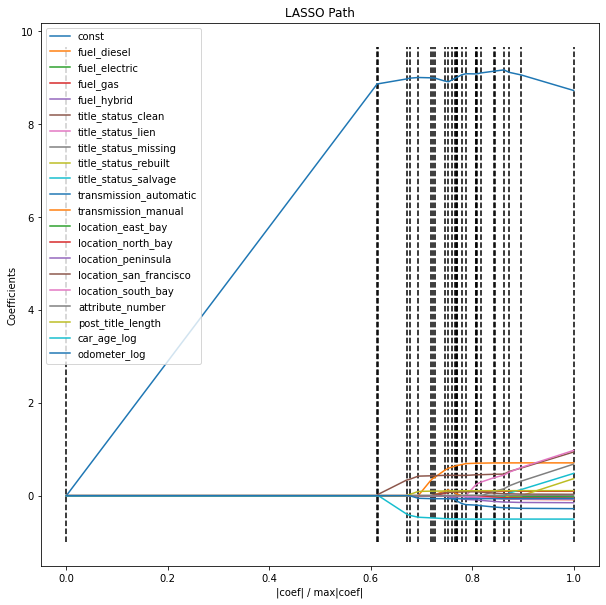

In [33]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

Analysis:<br/>
The constant variable is most important and has the highest coefficient value. There are too many features in this to interpret. I need to narrow down my features before running this again.

Thoughts after first exploratory regression:
Removing the following columns because of few data points and/or 0 beta coefficient in LASSO model
* fuel_electric (too few data points and 0 coefficient from LASSO)
* title_status_lien, title_status_missing, title_status_rebuilt (too few datapoints and 0 coefficient from LASSO)
* transmission_manual (too few data points and 0 coefficient from LASSO)
* location_east_bay and location_north_bay

In [151]:
car_df["fuel"].value_counts()

gas         5068
other        332
hybrid       300
diesel       280
electric      87
Name: fuel, dtype: int64

In [152]:
car_df["transmission"].value_counts()

automatic    5529
manual        438
other         100
Name: transmission, dtype: int64

In [155]:
car_df["location"].value_counts()

east_bay         2566
south_bay        1425
north_bay         751
san_francisco     656
peninsula         488
santa_cruz        181
Name: location, dtype: int64

In [19]:
car_df["title_status"].value_counts()

clean         5840
salvage        186
missing         14
rebuilt         13
lien            12
parts only       2
Name: title_status, dtype: int64

#### Exploration two <br/>
Dropping more columns: fuel_electric, title_status_lien, title_status_missing, title_status_rebuilt, transmission_manual, location_east_bay, and location_north_bay. 

Since I'm removing transmission_manual and almost all other values (5500+ values) are transmission_automatic, the entire transmission column can be removed.

In [93]:
car_df.head()

,fuel,odometer,title_status,transmission,year,price,location,attribute_number,post_title_length,car_age,car_age_log,odometer_log,price_log
0,gas,160000.0,salvage,automatic,2013,10300.0,east_bay,13,43,8,2.079442,11.982929,9.239899
1,gas,36368.0,clean,automatic,2017,34800.0,north_bay,15,25,4,1.386294,10.501445,10.457373
2,gas,59541.0,clean,other,2013,17900.0,santa_cruz,13,42,8,2.079442,10.994420,9.792556
3,gas,102693.0,clean,automatic,2013,8499.0,san_francisco,12,38,8,2.079442,11.539499,9.047704
4,gas,64183.0,clean,automatic,2012,6499.0,san_francisco,12,39,9,2.197225,11.069494,8.779404


In [94]:
# recreating my training and test Datasets with more features removed
remove_cols = ["odometer", "transmission", "year", "car_age", "price", "price_log"]
remove_dummy_cols = ["fuel_other", "fuel_electric", "title_status_missing", "title_status_rebuilt", \
                     "title_status_lien", "title_status_parts only","location_east_bay", "location_north_bay", \
                     "location_santa_cruz"]
X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = make_train_test(X, Y)

In [95]:
second_model = sm.OLS(Y_train, X_train)
fit = second_model.fit()

Y_pred = fit.predict(X_test)
print("R^2 Score for test: " + str(r2_score(Y_test, Y_pred)))

fit.summary()

R^2 Score for test: 0.5110136655772074


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     348.1
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:53:59   Log-Likelihood:                -4620.9
No. Observations:                4853   AIC:                             9268.
Df Residuals:                    4840   BIC:                             9352.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9.0288      0.123     73.360      0.000       8.787       9.270
fuel_diesel                0.7117      0.054     13.076      0.000       0.605       0.818
fuel_gas                   0.0999      0.036      2.753      0.006       0.029       0.171
fuel_hybrid               -0.0532      0.053     -1.007      0.314      -0.157       0.050
title_status_clean         0.3163      0.119      2.652      0.008       0.082       0.550
title_status_salvage      -0.1562      0.130     -1.204      0.229      -0.411       0.098
location_peninsula        -0.0898      0.034     -2.632      0.009      -0.157      -0.023
location_san_francisco     0.1005      0.030      3.330      0.001       0.041       0.160
location_south_bay        -0.0249      0.022     -1.113      0.266      -0.069       0.019
attribute_number           0.0080      0.009      0.876      0.381      -0.010       0.026
post_title_length          0.1036      0.009     11.099      0.000       0.085       0.122
car_age_log               -0.4943      0.011    -46.943      0.000      -0.515      -0.474
odometer_log              -0.0684      0.010     -6.614      0.000      -0.089      -0.048
==============================================================================
Omnibus:                      955.157   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10859.078
Skew:                          -0.604   Prob(JB):                         0.00
Kurtosis:                      10.228   Cond. No.                         38.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R^2 went down slightly to 0.463 (adjusted to 0.462) from 0.469 / 0.467. Run LassoCV again to see if there are more features to remove. There are quite a few values (fuel_hybrid, title_status_salvage, location_south_bay, and attribute_number) that have high p values. That means the chance to get this coefficient value if there is no relationship between that price_log and that feature is pretty high. I need to keep these features in mind as potential features to remove.

In [96]:
alpha_range = 10**np.linspace(-10,10,1000)
lasso_model = LassoCV(alphas=alpha_range, cv=5)
lasso_model.fit(X_train, Y_train);

print("Best Lasso alpha : " + str(lasso_model.alpha_))
print(list(zip(X_train.columns, lasso_model.coef_)))

test_set_pred = lasso_model.predict(X_test)
print("Mean absolute error : " + str(mae(Y_test, test_set_pred)))
print("R^2 score: " + str(r2_score(Y_test, test_set_pred)))

Best Lasso alpha : 2.7889802923804396e-05
[('const', 0.0), ('fuel_diesel', 0.7106768828718886), ('fuel_gas', 0.09934549021878376), ('fuel_hybrid', -0.05313616866328293), ('title_status_clean', 0.3166557210040255), ('title_status_salvage', -0.15485072932095464), ('location_peninsula', -0.08941333685436686), ('location_san_francisco', 0.10026240947791075), ('location_south_bay', -0.024730798953934843), ('attribute_number', 0.007974954697748698), ('post_title_length', 0.10363664507242266), ('car_age_log', -0.4942520664188982), ('odometer_log', -0.0683644625261839)]
Mean absolute error : 0.4282009607340732
R^2 score: 0.5110132895286512


Interestingly, no coefficient goes to zero except for the constant. However, based on the p values and low coefficient in LassoCV, I am thinking of removing the following columns:
location_south_bay, attribute_number, and fuel_hybrid. 
Additionally, Title status salvage also has very little values. The majority of vehicles have title status clean, so the entire title status column can be removed.

Trying LARS again. Will I see a clearer picture of what features are more important to predicting my target variable?

In [97]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train.values, Y_train.values, method='lasso')

Computing regularization path using the LARS ...


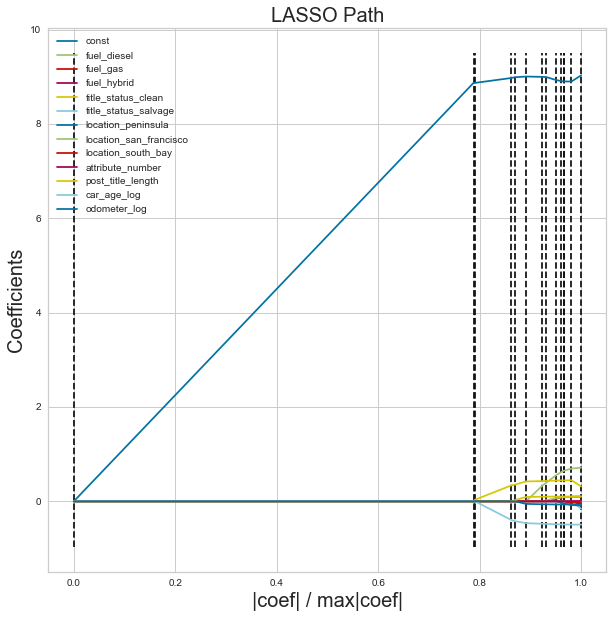

In [100]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|', fontsize=20)
plt.ylabel('Coefficients', fontsize=20)
plt.title('LASSO Path', fontsize=20)
plt.axis('tight')
plt.legend(X_train.columns)
plt.savefig("images/lars_path.png",format='png');

Analysis:<br/>
Again, my constant variable dominates and it's hard to interpret this graph. I can clearly see that odometer_log and diesel are pretty important features.

After looking at the p-values in the OLS summary table, the LASSO coefficients, and this LARS graph, I remove attribute_number and fuel_hybrid. Also, the title status will be entirely removed. Additionally, attribute number had a relatively high p-value, and I want to try removing this feature.

In [48]:
car_df["location"].value_counts()

east_bay         2566
south_bay        1425
north_bay         751
san_francisco     656
peninsula         488
santa_cruz        181
Name: location, dtype: int64

In [34]:
car_df["fuel"].value_counts()

gas         5068
other        332
hybrid       300
diesel       280
electric      87
Name: fuel, dtype: int64

#### Exploration 3 <br />
Removing attribute number, fuel hybrid, and all title status features. Since the majority of cars are gas, I will also remove that fuel column. The only fuel attribute I am keeping is diesel.

In [32]:
car_df.head()

,fuel,odometer,title_status,transmission,year,price,location,attribute_number,post_title_length,car_age,car_age_log,odometer_log,price_log
0,gas,160000.0,salvage,automatic,2013,10300.0,east_bay,13,43,8,2.079442,11.982929,9.239899
1,gas,36368.0,clean,automatic,2017,34800.0,north_bay,15,25,4,1.386294,10.501445,10.457373
2,gas,59541.0,clean,other,2013,17900.0,santa_cruz,13,42,8,2.079442,10.994420,9.792556
3,gas,102693.0,clean,automatic,2013,8499.0,san_francisco,12,38,8,2.079442,11.539499,9.047704
4,gas,64183.0,clean,automatic,2012,6499.0,san_francisco,12,39,9,2.197225,11.069494,8.779404


In [89]:
remove_cols = ["odometer", "transmission", "title_status", "year", "attribute_number", "car_age", "price", "price_log"]
remove_dummy_cols = ["fuel_other", "fuel_electric", "fuel_hybrid", "fuel_gas", "location_east_bay", \
                     "location_north_bay", "location_santa_cruz"]

X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = make_train_test(X, Y)

In [90]:
third_model = sm.OLS(Y_train, X_train)
fit = third_model.fit()

Y_pred = fit.predict(X_test)
print("R^2 Score for test: " + str(r2_score(Y_test, Y_pred)))

fit.summary()

R^2 Score for test: 0.4995589746033986


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     570.0
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:30:50   Log-Likelihood:                -4672.8
No. Observations:                4853   AIC:                             9362.
Df Residuals:                    4845   BIC:                             9414.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9.4122      0.012    774.075      0.000       9.388       9.436
fuel_diesel                0.6353      0.043     14.644      0.000       0.550       0.720
location_peninsula        -0.0912      0.034     -2.656      0.008      -0.158      -0.024
location_san_francisco     0.0880      0.030      2.893      0.004       0.028       0.148
location_south_bay        -0.0163      0.022     -0.726      0.468      -0.060       0.028
post_title_length          0.1067      0.009     11.363      0.000       0.088       0.125
car_age_log               -0.4968      0.010    -47.434      0.000      -0.517      -0.476
odometer_log              -0.0575      0.010     -5.567      0.000      -0.078      -0.037
==============================================================================
Omnibus:                      945.733   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10806.280
Skew:                          -0.593   Prob(JB):                         0.00
Kurtosis:                      10.214   Cond. No.                         5.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Very happy with almost all p values that are very low, but the R^2 went down. Only location_south_bay still has a high P value. Run LassoCV again.

In [40]:
alpha_range = 10**np.linspace(-10,10,1000)
lasso_model = LassoCV(alphas=alpha_range, cv=5)
lasso_model.fit(X_train, Y_train);

print("Best Lasso alpha : " + str(lasso_model.alpha_))
print(list(zip(X_train.columns, lasso_model.coef_)))

test_set_pred = lasso_model.predict(X_test)
print("Mean absolute error : " + str(mae(Y_test, test_set_pred)))
print("R^2 score: " + str(r2_score(Y_test, test_set_pred)))

Best Lasso alpha : 0.0004232789065573553
[('const', 0.0), ('fuel_diesel', 0.6265481547415603), ('location_peninsula', -0.08525161118322061), ('location_san_francisco', 0.08549050308514196), ('location_south_bay', -0.01386430839361323), ('post_title_length', 0.10657878642371071), ('car_age_log', -0.4964883288946317), ('odometer_log', -0.05745613094746217)]
Mean absolute error : 0.43512082197425533
R^2 score: 0.49937557126200716


#### Exploration 4
I am getting more happy with my model, but this time I remove location_south_bay. I also remove post_title_length just to see the affect on the model. Each extra character in a post title shouldn't directly result in an increase in car price (that's ridiculous!).

In [7]:
remove_cols = ["odometer", "transmission", "title_status", "year", "attribute_number", "post_title_length", "car_age", "price", "price_log"]
remove_dummy_cols = ["fuel_other", "fuel_electric", "fuel_hybrid", "fuel_gas", "location_east_bay", "location_north_bay", \
                     "location_south_bay", "location_santa_cruz"]

X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = make_train_test(X, Y)

In [8]:
fourth_model = sm.OLS(Y_train, X_train)
fit = fourth_model.fit()

Y_pred = fit.predict(X_test)
print("R^2 Score for test: " + str(r2_score(Y_test, Y_pred)))

fit.summary()

R^2 Score for test: 0.4861213298522976


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     752.5
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:57:44   Log-Likelihood:                -4736.7
No. Observations:                4853   AIC:                             9485.
Df Residuals:                    4847   BIC:                             9524.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9.4023      0.010    904.675      0.000       9.382       9.423
fuel_diesel                0.6772      0.044     15.470      0.000       0.591       0.763
location_peninsula        -0.0893      0.034     -2.617      0.009      -0.156      -0.022
location_san_francisco     0.1244      0.030      4.155      0.000       0.066       0.183
car_age_log               -0.5169      0.010    -49.440      0.000      -0.537      -0.496
odometer_log              -0.0589      0.010     -5.626      0.000      -0.079      -0.038
==============================================================================
Omnibus:                      872.536   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8865.148
Skew:                          -0.553   Prob(JB):                         0.00
Kurtosis:                       9.528   Cond. No.                         5.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
alpha_range = 10**np.linspace(-10,10,1000)
lasso_model = LassoCV(alphas=alpha_range, cv=5)
lasso_model.fit(X_train, Y_train);

print("Best Lasso alpha : " + str(lasso_model.alpha_))
print(list(zip(X_train.columns, lasso_model.coef_)))

test_set_pred = lasso_model.predict(X_test)
print("Mean absolute error : " + str(mae(Y_test, test_set_pred)))
print("R^2 score: " + str(r2_score(Y_test, test_set_pred)))

Best Lasso alpha : 0.00015352750287804211
[('const', 0.0), ('fuel_diesel', 0.6740267953210433), ('location_peninsula', -0.08745797013004414), ('location_san_francisco', 0.1232593492386158), ('car_age_log', -0.5167421253750752), ('odometer_log', -0.0588151898670191)]
Mean absolute error : 0.4414037026489973
R^2 score: 0.48605376736980666


Finally happy with my model. My P values are generally low. The coefficients for LASSO and OLS from statsmodel look similar. My R^2 dropped a little bit, but not significantly. I have more trust in the robustness of this model and that it may be less overfitting than my previous model.

#### 4. Cross-Validation

In [12]:
# set up my X_train, X_test, Y_train, and Y_test for cross validation
remove_cols = ["odometer", "transmission", "title_status", "year", "attribute_number", "post_title_length", "car_age", "price", "price_log"]
remove_dummy_cols = ["fuel_other", "fuel_electric", "fuel_hybrid", "fuel_gas", "location_east_bay", "location_north_bay", \
                     "location_south_bay", "location_santa_cruz"]

X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = make_train_test(X, Y)

Testing Linear Regression Model

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=20)

lr_scores = []

for train_ind, val_ind in kf.split(X_train, Y_train):

    X_train_kf = X_train.iloc[train_ind]
    Y_train_kf = Y_train.iloc[train_ind]
    X_val_kf = X_train.iloc[val_ind]
    Y_val_kf = Y_train.iloc[val_ind]
    
    lr_model = LinearRegression()
    lr_model.fit(X_train_kf, Y_train_kf)
    
    lr_scores.append(lr_model.score(X_val_kf, Y_val_kf))
    
print(lr_scores)
print(f'The mean R^2 score is: {np.mean(lr_scores)} and the standard deviation is: {np.std(lr_scores)}')

[0.4674748327922372, 0.44793578220264385, 0.38985974167803505, 0.40319006473680263, 0.4772406085691986]
The mean R^2 score is: 0.4371402059957835 and the standard deviation is: 0.034735661020555954


Testing LASSO

In [15]:
alpha_range = 10**np.linspace(-5,5,1000)
lasso_model = LassoCV(alphas=alpha_range, cv=5)
lasso_model.fit(X_train, Y_train)

best_lasso_alpha = lasso_model.alpha_
print("The best alpha for lasso is: " + str(best_alpha))

The best alpha for lasso is: 0.00015176833902834055


In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=20)

lasso_scores = []

for train_ind, val_ind in kf.split(X_train, Y_train):

    X_train_kf = X_train.iloc[train_ind]
    Y_train_kf = Y_train.iloc[train_ind]
    X_val_kf = X_train.iloc[val_ind]
    Y_val_kf = Y_train.iloc[val_ind]
    
    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_train_kf, Y_train_kf)
    
    lasso_scores.append(lasso_model.score(X_val_kf, Y_val_kf))
    
print(lasso_scores)
print(f'The mean R^2 score is: {np.mean(lasso_scores)} and the standard deviation is: {np.std(lasso_scores)}')

[0.46747082186442623, 0.4479313915347143, 0.3898852774634878, 0.4031622566851033, 0.4772698960806253]
The mean R^2 score is: 0.4371439287256714 and the standard deviation is: 0.03473994015904513


Testing Ridge

In [18]:
alpha_range = 10**np.linspace(-5,5,1000)
ridge_model = RidgeCV(alphas=alpha_range, cv=5)
ridge_model.fit(X_train, Y_train)

best_ridge_alpha = ridge_model.alpha_
print("The best alpha for ridge is: " + str(best_alpha))

The best alpha for ridge is: 1.5317404637020797


In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=20)

ridge_scores = []

for train_ind, val_ind in kf.split(X_train, Y_train):

    X_train_kf = X_train.iloc[train_ind]
    Y_train_kf = Y_train.iloc[train_ind]
    X_val_kf = X_train.iloc[val_ind]
    Y_val_kf = Y_train.iloc[val_ind]
    
    ridge_model = Ridge(alpha=best_ridge_alpha)
    ridge_model.fit(X_train_kf, Y_train_kf)
    
    ridge_scores.append(ridge_model.score(X_val_kf, Y_val_kf))
    
print(ridge_scores)
print(f'The mean R^2 score is: {np.mean(ridge_scores)} and the standard deviation is: {np.std(ridge_scores)}')

[0.46745253896252137, 0.4478632339497671, 0.3898064946579275, 0.4031726439487531, 0.47751473825665525]
The mean R^2 score is: 0.4371619299551249 and the standard deviation is: 0.03480861058547084


Now, I want to generate boxplots to show my cross validation results.

In [42]:
cross_val_df = pd.DataFrame(columns=['Model', 'R^2 Score'])
validation_dict = {'least_squares': lr_scores, 'lasso': lasso_scores, 'ridge': ridge_scores}
model_list = []
scores_list = []
for model_name, scores in validation_dict.items():
    for score in scores:
        model_list.append(model_name)
        scores_list.append(score)

In [43]:
print(list(zip(model_list, scores_list)))

[('least_squares', 0.4674748327922372), ('least_squares', 0.44793578220264385), ('least_squares', 0.38985974167803505), ('least_squares', 0.40319006473680263), ('least_squares', 0.4772406085691986), ('lasso', 0.46747082186442623), ('lasso', 0.4479313915347143), ('lasso', 0.3898852774634878), ('lasso', 0.4031622566851033), ('lasso', 0.4772698960806253), ('ridge', 0.46745253896252137), ('ridge', 0.4478632339497671), ('ridge', 0.3898064946579275), ('ridge', 0.4031726439487531), ('ridge', 0.47751473825665525)]


In [45]:
cross_val_df = pd.DataFrame({'Model': model_list, 'R^2 Score': scores_list})
cross_val_df

,Model,R^2 Score
0,least_squares,0.467475
1,least_squares,0.447936
2,least_squares,0.389860
3,least_squares,0.403190
4,least_squares,0.477241
5,lasso,0.467471
6,lasso,0.447931
7,lasso,0.389885
8,lasso,0.403162
9,lasso,0.477270


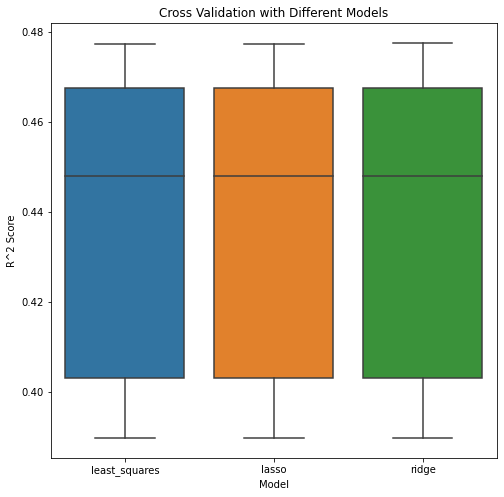

In [48]:
plt.figure(figsize=(8,8))
sns.boxplot(x='Model', y='R^2 Score', data=cross_val_df)
plt.title('Cross Validation with Different Models');

Awesome! I tested cross validated my model with Linear Regression, LASSO, and Ridge. All of them show similar R^2 scores and standard deviations.

Finally, I would like to test on my original X_test and Y_text. It doesn't look like Ridge or Lasso offer any benefits over least squares linear regression, so my final model will be based on the LinearRegression from scikitlearn. This uses the ordinary least square linear regression model to my data.

In [7]:
remove_cols = ["odometer", "transmission", "title_status", "year", "attribute_number", "post_title_length", "car_age", "price", "price_log"]
remove_dummy_cols = ["fuel_other", "fuel_electric", "fuel_hybrid", "fuel_gas", "location_east_bay", "location_north_bay", \
                     "location_south_bay", "location_santa_cruz"]

X = make_X_df(car_df, remove_cols, remove_dummy_cols)
Y = car_df["price_log"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=20)
    
# Scale the data
scaler = StandardScaler()
    
master_numeric_cols = ["attribute_number", "post_title_length", "car_age_log", "odometer_log"]
numeric_cols = []
    
# if attribute number or post title length are removed as features, don't scale for those columns
for column in X.columns:
    if column in master_numeric_cols:
        numeric_cols.append(column)
    
scaler.fit(X_train[numeric_cols])
    
scaled_train_values = scaler.transform(X_train[numeric_cols])

# save the standard deviations for later beta coefficient interpretation
scaler_std = dict(zip(numeric_cols, np.sqrt(scaler.var_)))

X_train = X_train.drop(columns=numeric_cols)
X_train[numeric_cols] = pd.DataFrame(scaled_train_values, index=X_train.index, columns=numeric_cols)
X_train = sm.add_constant(X_train)
    
scaled_test_values = scaler.transform(X_test[numeric_cols])
X_test = X_test.drop(columns=numeric_cols)
X_test[numeric_cols] = pd.DataFrame(scaled_test_values, index=X_test.index, columns=numeric_cols)
X_test = sm.add_constant(X_test)

In [58]:
scaler_std

{'car_age_log': 0.7638103380784207, 'odometer_log': 1.6791390141332898}

In [8]:
final_lr_model = LinearRegression(fit_intercept=False)

In [9]:
final_lr_model.fit(X_train, Y_train)
print(list(zip(X_train.columns, final_lr_model.coef_))); # coefficients are with scaled data

[('const', 9.402325898511807), ('fuel_diesel', 0.6772415529986688), ('location_peninsula', -0.08934753314432659), ('location_san_francisco', 0.12443193201974181), ('car_age_log', -0.5168643535199745), ('odometer_log', -0.05886055364245324)]


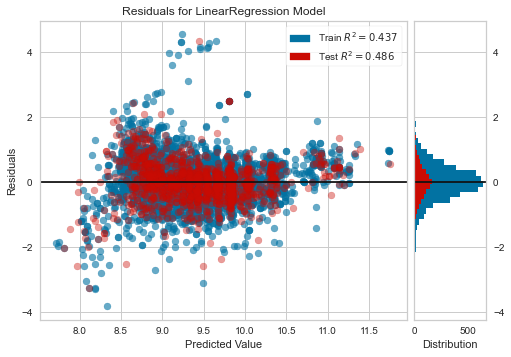

In [22]:
visualizer = ResidualsPlot(final_lr_model, train_color='b', test_color='r',train_alpha=0.6, test_alpha=0.4)
visualizer.fit(X_train, Y_train)
visualizer.score(X_test, Y_test)
visualizer.show(outpath="images/residual_plot.png");

In [76]:
# get seaborn GnBu color palette hex colors to match colors from previous visualizations
print(sns.color_palette("GnBu").as_hex())

['#ddf2d8', '#c2e7c0', '#95d6bb', '#61bdcd', '#3597c4', '#0d6dae']


In [142]:
X_test_unscaled = pd.DataFrame(scaler.inverse_transform(scaled_test_values), index=X_test.index, columns=numeric_cols)
X_test_unscaled.head()

,car_age_log,odometer_log
1912,1.386294,10.658717
1786,2.302585,11.589887
2931,2.079442,11.658056
936,2.564949,11.652687
141,0.693147,10.104631


In [145]:
X_train_unscaled = pd.DataFrame(scaler.inverse_transform(scaled_train_values), index=X_train.index, columns=numeric_cols)
X_train_unscaled.head()

,car_age_log,odometer_log
2107,0.693147,10.666091
2206,1.791759,10.769453
2047,0.693147,9.875140
2502,2.890372,12.038931
511,2.197225,11.813030


In [23]:
# My final test. Testing my final Linear Regression model on my test data.
print(final_lr_model.score(X_test, Y_test))
# got an R^2 around 0.48 on the test data, which is higher than my model's R^2

0.4861213298522974


The R^2 score when testing against my test data is around 0.48, which is higher than my model's R^2 of 0.437. This number is obtained from the statsmodel OLS from exploration 4.

In [27]:
print(list(zip(X_train.columns, np.round(final_lr_model.coef_, 3))))

[('const', 9.402), ('fuel_diesel', 0.677), ('location_peninsula', -0.089), ('location_san_francisco', 0.124), ('car_age_log', -0.517), ('odometer_log', -0.059)]


Here is the final regression formula I have. Note that the numeric columns (car_age_log and odometer_log) need to be rescaled. Currently, the coefficients are based on the StandardScaler transformation that turns them into unitless z-scores.

price_log = 9.40 + 0.677 * fuel_diesel - 0.089 * location_peninsula + 0.124 * location_san_francisco - 0.517 * car_age_log - 0.059 * odometer_log

Now, I want to interpret my beta coefficients.

Rescale my car_age_log and odometer_log coefficients.

In [161]:
scaler_std

{'car_age_log': 0.7638103380784207, 'odometer_log': 1.6791390141332898}

In [32]:
# rescale car_age_log and odometer_log coefficients
beta_coefs = dict(zip(X_train.columns, final_lr_model.coef_))
rescaled_beta_coefs = dict()

for feature in beta_coefs.keys():
    if feature in scaler_std.keys():
        rescaled_beta_coefs[feature] = beta_coefs[feature] / scaler_std[feature]
    else:
        rescaled_beta_coefs[feature] = beta_coefs[feature]
rescaled_beta_coefs

{'const': 9.402325898511807,
 'fuel_diesel': 0.6772415529986688,
 'location_peninsula': -0.08934753314432659,
 'location_san_francisco': 0.12443193201974181,
 'car_age_log': -0.6766920107683956,
 'odometer_log': -0.03505400871936437}

Now I have the correctly scaled beta coefficients.<br/>
Categorical variables (c)

$\log(price)$ = $\beta$ * c 

if categorical_variable is 0:
price = $e^{\beta * c}$
price = $e^{\beta * 0}$
price = 1


if categorical_variable is 1:
new price = $e^{\beta * c}$
new price = $e^{\beta * 1}$
new price = $e^{\beta}$

$\frac{new price}{price}$ = $e^{\beta}$<br/>
($\frac{new price}{price}$ - $\frac{price}{price}$) * 100 = ($e^{\beta}$ - 1) * 100<br/>
% change in price = ($e^{\beta}$ - 1) * 100<br/>
If the categorical variable is 1 (or true), the price changes by this %.

Numerical variables (n)<br/>
When both the target and feature are both log transformed:<br/>
<br/>
$\log(price)$ = $\beta$ * $\log(n1)$<br/>
<br/>
$\log(newprice)$ = $\beta$ * $\log(n2)$<br/><br/>
$\log(newprice)$ - $\log(price)$ = $\beta$ * $\log(n2)$ - $\beta$ * $\log(n1)$<br/><br/>
$\log(\frac{newprice}{price})$ = $\beta$ * $\log(\frac{n2}{n1})$<br/><br/>
$\frac{new price}{price}$ = $\frac{n2}{n1}^\beta$<br/><br/>
($\frac{new price}{price}$ - $\frac{price}{price}$) * 100 = ($\frac{n2}{n1}^\beta$ - 1) * 100<br/><br/>
% changes in price = ($\frac{n2}{n1}^\beta$ - 1) * 100

if $\frac{n2}{n1}$ is 1.1 (increases by 10%), then you can calculate change in price as $(1.1^\beta)$ - 1) * 100

In [33]:
rescaled_beta_coefs

{'const': 9.402325898511807,
 'fuel_diesel': 0.6772415529986688,
 'location_peninsula': -0.08934753314432659,
 'location_san_francisco': 0.12443193201974181,
 'car_age_log': -0.6766920107683956,
 'odometer_log': -0.03505400871936437}

Look at my categorical variables. 
Car posts in San Francisco list prices 13.25% higher than normal. Car posts in the peninsula region list prices 8.55% cheaper than normal.

In [34]:
print((np.exp(rescaled_beta_coefs["location_san_francisco"]) - 1) * 100)
print((np.exp(rescaled_beta_coefs["location_peninsula"]) - 1) * 100)

13.250493051334411
-8.547231034350734


In [167]:
np.exp(rescaled_beta_coefs["car_age_log"] * 1.01)

0.5048676663513385

In [37]:
numeric_cols = ["attribute_number", "post_title_length", "car_age_log", "odometer_log"]
log_cols = ["car_age_log", "odometer_log"]

for feature in rescaled_beta_coefs.keys():
    # if the feature is numeric
    if feature in numeric_cols:
        # if the feature is log transformed
        if feature in log_cols:
            print(f'If {feature} untransformed is increased by 10%, then price changes by {((1.1**(rescaled_beta_coefs[feature]) - 1) * 100)}%')
        
    # if the feature is categorical    
    else:
        print(f'If {feature} is 1, then price changes by {(np.exp(rescaled_beta_coefs[feature])-1) * 100}%')

If const is 1, then price changes by 1211552.980021748%
If fuel_diesel is 1, then price changes by 96.84403978660548%
If location_peninsula is 1, then price changes by -8.547231034350734%
If location_san_francisco is 1, then price changes by 13.250493051334411%
If car_age_log untransformed is increased by 10%, then price changes by -6.245979546379976%
If odometer_log untransformed is increased by 10%, then price changes by -0.33354289308259455%


Human interpretable terms:<br/>
I don't need to worry about the constant value.

All other things held constant, if a car is a diesel car rather another type of fuel, the price is 96.8% higher.

If the post was made in the Peninsula, then the price is around 8.5% cheaper.
If the post was made in San Francisco, then the price is around 13.3% more expensive.

For every 10% increase in car age by year, price lowers by 6.24%.
Example: 10 year old car original price is 10,000 dollars. The 11 year old car would be 624 dollars cheaper, or 9,376 dollars.

For every 10% increase in odometer mile reading, price lowers by 0.33%.
Example: Car with 10,000 odometer reading is 10,000 dollars. A car with 11,000 odometer reading would be 33 dollars cheaper, or 9,967 dollars.